# Libraries

In [2]:
# for local import
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [3]:
# for working with data
import pandas as pd
import numpy as np
import scipy.sparse

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# for preprocessing
from src.preprocessing import BasicTextCleaning
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# for modelling
from sklearn.linear_model import LogisticRegression

# for evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# Load Data

In [4]:
osf = pd.read_csv("../../data/fake_reviews_dataset.csv")
print("Shape of OFS: ", osf.shape)
# osf.head()
osf

Shape of OFS:  (40432, 4)


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


# Preprocessing

### Basic Text Cleaning

In [5]:
cleaner = BasicTextCleaning()

In [6]:
try:
    osf_cleaned = pd.read_csv("../../data/cleaned/osf_cleaned.csv")
    osf_cleaned = osf_cleaned.replace(np.nan, '')
except:
    osf_cleaned = pd.DataFrame()
    osf_cleaned['length'] = osf['text_'].apply(lambda x: len(x))
    osf_cleaned['texts'] = cleaner.text_cleaning(osf['text_'])

    ordinal = OrdinalEncoder(categories=[['OR', 'CG']], dtype=int)
    osf_cleaned['labels'] = ordinal.fit_transform(osf[['label']])
    osf_cleaned.to_csv("../../data/cleaned/osf_cleaned.csv", index=False)

In [7]:
from nltk import ngrams

class AvgWord2Vec:
    def __init__(self, vector_size=300, min_count=1, sg=1, ngram_range=(1, 1), window=5, epochs=5, seed=42):
        self.w2v = Word2Vec(vector_size=vector_size, min_count=min_count, sg=sg,
                            window=window, workers=5, seed=seed, epochs=epochs)
        self.min_count = min_count
        self.sg = sg
        self.window = window
        self.seed = seed
        self.vsize = vector_size
        self.epochs = epochs

        self.ngrams = np.arange(ngram_range[0], ngram_range[1]+1, 1)
        self.raw = None
        self.corpus = None
        self.vocabulary_ = None

    def _create_ngrams(self, n, X):
        phrases = [list(ngrams(sent.split(), n)) for sent in X]
        for i in range(len(phrases)):
            phrases[i] = [" ".join(word) for word in phrases[i]]
        return phrases
    
    def _create_corpus(self, X, update_train=False):
        ngrams_phrases = {}
        for n in self.ngrams:
            phrases = self._create_ngrams(n, X)
            ngrams_phrases[f"{n}"] = phrases
        data = []
        corpus = []
        for n in ngrams_phrases.values():
            if len(data)==0:
                data = n
            data = [data[i] + n[i] for i in range(len(data))]
            corpus.extend(n)
        if update_train:
            self.corpus = corpus
        return data
    
    def _avg_sentence(self, data):
        avg_sentences = []
        for sent in data:
            if len(sent)!=0:
                avg_sentence = np.mean([self.w2v.wv.get_vector(word) for word in sent
                                        if word in self.w2v.wv.index_to_key], axis=0)
            else:
                avg_sentence = np.zeros(self.vsize)
            avg_sentences.append(avg_sentence)
        return np.array(avg_sentences)

    def fit(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=5, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)
        self._create_corpus(update_train=True, X=X)
        self.w2v.build_vocab(self.corpus)
        self.w2v.train(self.corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        self.vocabulary_ = self.w2v.wv.key_to_index

    def fit_transform(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=5, seed=self.seed, epochs=self.epochs)
        self.raw = list(X)
        data = self._create_corpus(update_train=True, X=X)
        self.w2v.build_vocab(self.corpus)
        self.w2v.train(self.corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        self.vocabulary_ = self.w2v.wv.key_to_index
        return scipy.sparse.csr_matrix(self._avg_sentence(data))
        
    def transform(self, X):
        data = self._create_corpus(update_train=False, X=X)
        return scipy.sparse.csr_matrix(self._avg_sentence(data))
    
    def get_feature_names_out(self):
        columns = np.array([f'component_{i+1}' for i in range(self.vsize)])

In [8]:
def avg_word2vec(sentences, w2v_model):
    avg_sentences = []
    for sentence in sentences:
        if sentence:
            avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence if word in w2v_model.wv.key_to_index], axis=0)
        else:
            avg_sentence = np.zeros(w2v_model.vector_size)
        avg_sentences.append(avg_sentence)
    return np.array(avg_sentences)

def text_extractor(X_train, X_test, extractor):
    if isinstance(extractor, Word2Vec):
        vector_size = extractor.vector_size
        window = extractor.window
        sg = extractor.sg
        extractor = Word2Vec(vector_size=vector_size, sg=sg, window=window, min_count=1, workers=5, seed=42)

        cleaner = BasicTextCleaning()
        X_train = cleaner.text_cleaning(texts=X_train, methods=['tokenization'])
        X_test = cleaner.text_cleaning(texts=X_test, methods=['tokenization'])

        extractor.build_vocab(X_train)
        extractor.train(X_train, total_examples=extractor.corpus_count, epochs=30)
        X_train = avg_word2vec(X_train, extractor)
        X_train = pd.DataFrame(X_train, columns=[str(i) for i in range(extractor.vector_size)])
        X_test = avg_word2vec(X_test, extractor)
        X_test = pd.DataFrame(X_test, columns=[str(i) for i in range(extractor.vector_size)])
    else:
        X_train = extractor.fit_transform(X_train).toarray()
        X_test = extractor.transform(X_test).toarray()
        X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
    variance = VarianceThreshold()
    X_train = variance.fit_transform(X_train)
    X_test = variance.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

    return X_train, X_test

def text_extractor(X_train, X_test, extractor):
    X_train = extractor.fit_transform(X_train).toarray()
    X_test = extractor.transform(X_test).toarray()
    X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
    variance = VarianceThreshold()
    X_train = variance.fit_transform(X_train)
    X_test = variance.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

    return X_train, X_test

def feature_selection(X_train, X_test, selector):
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=selector.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=selector.get_feature_names_out())
    
    return X_train, X_test

In [9]:
def modelling(model, X_train, y_train, X_test, probability=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if probability:
        y_pred_proba = model.predict_proba(X_test)
        return y_pred, y_pred_proba
    return y_pred

def evaluation(y_true, y_pred, y_pred_prob, scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

In [10]:
def cross_validation(data, extractor, model=None, selector=None, length_scaler=None,
                     scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5,
                     avg_output=True, quiet=True):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = {method: [] for method in scoring}
    round = 1

    for train_indices, test_indices in kfolds.split(data.iloc[:, :-1], data.iloc[:, -1]):
        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)

        if length_scaler is not None:
            X_train['length'] = length_scaler.fit_transform(train_set[['length']])
            X_test['length'] = length_scaler.transform(test_set[['length']])
        
        if selector is not None:
            X_train, X_test = feature_selection(X_train, X_test, selector)

        y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)

        result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
        for method in scoring:
            scores[method].append(result[method])
            
        if not quiet:
            print(f"round {round}: done")

        round += 1
        
    if avg_output:
        avg_scores = {key: np.mean(values) for key, values in scores.items()}

    return avg_scores

In [10]:
# extractor = AvgWord2Vec(window=10, vector_size=300, seed=42, sg=1)
# model = LogisticRegression(max_iter=1000, class_weight="balanced")
# # model = SVC(probability=True, class_weight='balanced')
# # extractor = TfidfVectorizer(min_df=0.001, ngram_range=(1, 1))
# # model = SVC()

# cross_validation(data=osf_cleaned, length_scaler=None,
#                  model=model, extractor=extractor, quiet=False)

# Define Testcases

### Testing for Different Window Sizes
<br>
Test if window size affect the performance of Word2Vec skipgrams and cbow.

* window size range (1, 21, 2)
* fixed other components
    * no length used nor feature selector
    * text Extractor: `AvgWord2Vec(vector_size=100, ngram_range=(1, 1))`
    * model: `LogisticRegression(max_iter=1000, class_weight='balanced)`

In [11]:
output = {'window': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for window in range(12, 16, 1):
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=300, window=window, sg=sg),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['window'].append(window)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        print(f"{output['w2v_type'][-1]} - window {window}: done")

skipgram - window 12: done
skipgram - window 13: done
skipgram - window 14: done
skipgram - window 15: done


In [13]:
# output_df = pd.DataFrame(output)
# output_df
# output_saved = pd.read_csv("../../output/define_testcases/w2v_window_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# # output_new.to_csv("../../output/define_testcases/w2v_window_test.csv", index=False)

In [23]:
# # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\r2_w2v_window_test_ggcolab_2.csv")
# output_saved = pd.read_csv("../../output/define_testcases/w2v_window_test.csv")
# output_saved
# output_new = pd.concat([output_saved.iloc[:15], output_outsource, output_saved.iloc[15:]], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_window_test.csv", index=False)

__Visualization__

In [24]:
window_size = pd.read_csv(r"..\..\output\define_testcases\w2v_window_test.csv")
window_size

,window,w2v_type,accuracy,f1,recall,precision,roc_auc
0,1,cbow,0.825262,0.827133,0.836307,0.818180,0.888993
1,2,cbow,0.828749,0.830358,0.838395,0.822491,0.893035
2,3,cbow,0.831841,0.833240,0.840415,0.826206,0.895036
3,4,cbow,0.834685,0.836149,0.843814,0.828629,0.897175
4,5,cbow,0.835600,0.836963,0.844122,0.829936,0.898960
5,6,cbow,0.836565,0.837800,0.844354,0.831360,0.899589
6,7,cbow,0.836986,0.838204,0.844702,0.831812,0.899824
7,8,cbow,0.837604,0.838802,0.845193,0.832507,0.901309
8,9,cbow,0.838692,0.839756,0.845501,0.834097,0.901779
9,10,cbow,0.838000,0.838923,0.843915,0.833994,0.901666


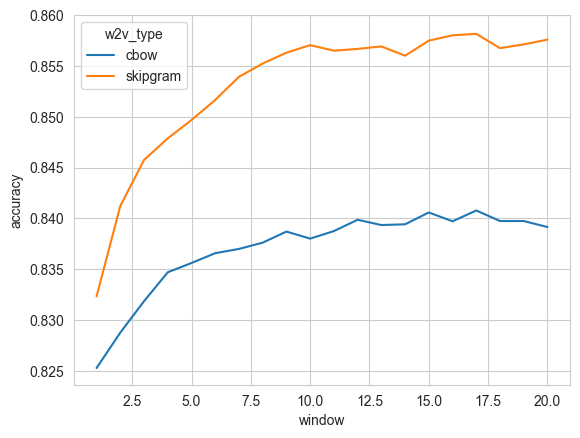

In [45]:
window_size = pd.read_csv(r"..\..\output\define_testcases\w2v_window_test.csv")
sns.lineplot(x=window_size['window'], y=window_size['accuracy'], hue=window_size['w2v_type'])
plt.ylim(top=0.86)
# plt.xticks(range(1, 21, 1))
plt.show()

### Testing for Different Vector Sizes
<br>
Test if window size affect the performance of Word2Vec skipgrams and cbow.

* window size range (1, 21, 2)
* fixed other components
    * no length used nor feature selector
    * text Extractor: `AvgWord2Vec(vector_size=100, ngram_range=(1, 1))`
    * model: `LogisticRegression(max_iter=1000, class_weight='balanced)`

In [10]:
output = {'vector_size': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for vector in range(900, 1100, 100):
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=vector, window=10, sg=sg),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['vector_size'].append(vector)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        print(f"{output['w2v_type'][-1]} - vector {vector}: done")

skipgram - vector 900: done
skipgram - vector 1000: done


In [12]:
# output_df = pd.DataFrame(output)
# output_saved = pd.read_csv("../../output/define_testcases/w2v_vectorsize_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_vectorsize_test.csv", index=False)

In [18]:
# # save file from other sources
# output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\r2_w2v_vectorsize_test_kaggle_1.csv")
# output_saved = pd.read_csv("../../output/define_testcases/w2v_vectorsize_test.csv")
# output_saved
# output_new = pd.concat([output_outsource, output_saved], axis=0, ignore_index=True)
# output_new
# # output_new.to_csv("../../output/define_testcases/w2v_vectorsize_test.csv", index=False)

__Visualization__

In [19]:
vector_size = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test.csv")
vector_size

,vector_size,w2v_type,accuracy,f1,recall,precision,roc_auc
0,100,cbow,0.837703,0.838745,0.844355,0.833211,0.901490
1,200,cbow,0.840052,0.840881,0.845566,0.836254,0.902593
2,300,cbow,0.838469,0.839506,0.845107,0.833985,0.902159
3,400,cbow,0.838346,0.839283,0.844385,0.834246,0.901508
4,500,cbow,0.837208,0.838164,0.843354,0.833048,0.901603
5,600,cbow,0.836837,0.837860,0.843323,0.832477,0.900597
6,700,cbow,0.837455,0.838505,0.844198,0.832892,0.900810
7,800,cbow,0.837851,0.838951,0.844930,0.833060,0.900736
8,900,cbow,0.836985,0.838010,0.843552,0.832549,0.900453
9,1000,cbow,0.836046,0.837040,0.842363,0.831794,0.900172


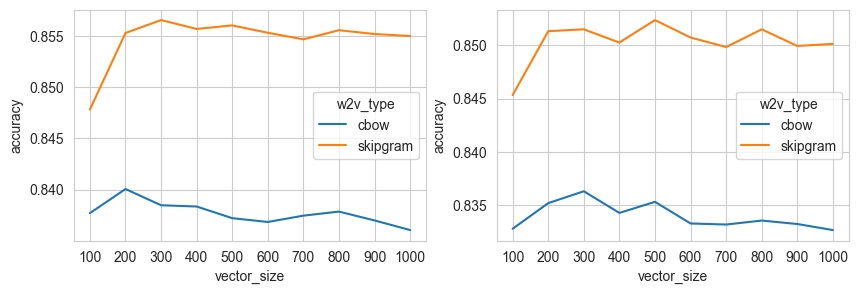

In [12]:
vector_size1 = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test.csv")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(x=vector_size1['vector_size'], y=vector_size1['accuracy'], hue=vector_size1['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
plt.xticks(range(100, 1100, 100))

vector_size2 = pd.read_csv(r"..\..\output\define_testcases\w2v_vectorsize_test_old.csv")
plt.subplot(1, 2, 2)
sns.lineplot(x=vector_size2['vector_size'], y=vector_size2['accuracy'], hue=vector_size2['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
plt.xticks(range(100, 1100, 100))
plt.show()

In [13]:
avg_vectorsize = vector_size1.iloc[:, :2].copy()
for col in vector_size1.columns[2:]:
    avg_vectorsize[col] = np.mean([vector_size1[col], vector_size2[col]], axis=0)
avg_vectorsize

,vector_size,w2v_type,accuracy,f1,recall,precision,roc_auc
0,100,cbow,0.835254,0.836417,0.842551,0.830386,0.898750
1,200,cbow,0.837629,0.838690,0.844462,0.833006,0.900784
2,300,cbow,0.837394,0.838485,0.844358,0.832703,0.900264
3,400,cbow,0.836318,0.837422,0.843367,0.831570,0.899812
4,500,cbow,0.836268,0.837340,0.843106,0.831663,0.899769
5,600,cbow,0.835069,0.836247,0.842454,0.830142,0.898509
6,700,cbow,0.835328,0.836467,0.842515,0.830510,0.898940
7,800,cbow,0.835712,0.836971,0.843629,0.830425,0.898994
8,900,cbow,0.835118,0.836289,0.842472,0.830205,0.898630
9,1000,cbow,0.834364,0.835604,0.842099,0.829220,0.898476


<Axes: xlabel='vector_size', ylabel='accuracy'>

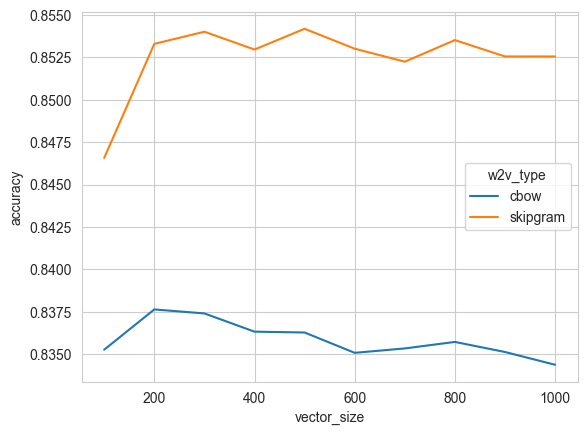

In [14]:
sns.lineplot(x=avg_vectorsize['vector_size'], y=avg_vectorsize['accuracy'], hue=avg_vectorsize['w2v_type'])
# plt.ylim(bottom=0.83, top=0.86)
# plt.xticks(range(100, 1100, 100))

### Testing for Different Epochs

In [10]:
import time

output = {'epochs': [],
          'w2v_type': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': []}

for sg in [1]:
    for epochs in range(35, 45, 5):
        start = time.time()
        scores = cross_validation(data=osf_cleaned,
                                  extractor=AvgWord2Vec(vector_size=300, window=5, sg=sg, epochs=epochs),
                                  model=LogisticRegression(max_iter=1000, class_weight="balanced"))
        output['epochs'].append(epochs)
        output['w2v_type'].append('cbow' if sg==0 else 'skipgram')
        for key, value in scores.items():
            output[key].append(value)
        durations = time.time() - start
        print(f"{output['w2v_type'][-1]} - epochs {epochs}: {int(durations//60)}m{int(durations%60)}s")

skipgram - epochs 35: 46m18s


KeyboardInterrupt: 

In [16]:
# output_df = pd.DataFrame(output)
# output_saved = pd.read_csv("../../output/define_testcases/w2v_epochs_test.csv")
# output_saved
# output_new = pd.concat([output_saved, output_df], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_epochs_test.csv", index=False)

In [24]:
# # save file from other sources
output_outsource = pd.read_csv(r"C:\Users\minhn\Downloads\w2v_epochs_test_ggcolab_5.csv")
output_outsource.loc[4, :] = {'epochs': 1,
                              'w2v_type': 2,
                              'accuracy': 1,
                              'f1': 1,
                              'recall': 2,
                              'precision': 0,
                              'roc_auc': 9}
output_outsource
# output_saved = pd.read_csv("../../output/define_testcases/w2v_epochs_test.csv")
# output_saved.iloc[:6]
# output_new = pd.concat([output_saved.iloc[:6, :], output_outsource, output_saved.iloc[6:, :]], axis=0, ignore_index=True)
# output_new
# output_new.to_csv("../../output/define_testcases/w2v_epochs_test.csv", index=False)

,epochs,w2v_type,accuracy,f1,recall,precision,roc_auc
0,35.0,cbow,0.859666,0.860621,0.866707,0.854621,0.921685
1,40.0,cbow,0.859443,0.860417,0.866612,0.854311,0.921945
2,45.0,cbow,0.858899,0.859849,0.865820,0.853965,0.922244
3,50.0,cbow,0.858132,0.859090,0.865077,0.853189,0.921439
4,1.0,2,1.000000,1.000000,2.000000,0.000000,9.000000


__Visualization__

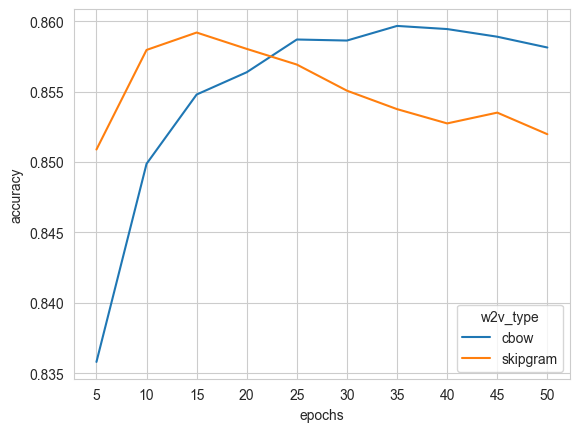

In [17]:
epochs_sizes = pd.read_csv(r"..\..\output\define_testcases\w2v_epochs_test.csv")
sns.lineplot(x=epochs_sizes['epochs'], y=epochs_sizes['accuracy'], hue=epochs_sizes['w2v_type'])
# plt.ylim(top=0.86)
plt.xticks(range(5, 55, 5))
plt.show()

# Model Testing
* `length` features:
    * None
    * MinMaxScaler
    * StandardScaler
* AvgWord2Vec:
    * Vector size = 300
    * Window = 10
    * ngrams = (1, 1) or (1, 2) or (1, 3)
* Model
    * Logistic Regression (baseline)
    * LightGBM
    * Catboost
    * (KNN)
    * (SVM)
    * (XGBoost)
    * (GradientBoost)

### LogisticRegression

In [51]:
from tqdm import tqdm

output = {'data': [],
          'length_used': [],
          'ngrams': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None,
                             'MinMaxScaler': MinMaxScaler(),
                             'StandardScaler': StandardScaler()},
             'ngrams': [(1, 1), (1, 2), (1, 3)],
             'feature_extraction': 'Word2Vec(vector_size=300, window=10)',
             'feature selection': {'None': None},
             'model': {'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced')}}

for length in testcases['length_used']:
    if length == 'None':
        data = osf_cleaned.iloc[:, 1:].copy()
    else:
        data = osf_cleaned.copy()
    for n in testcases['ngrams']:
        extractor = AvgWord2Vec(vector_size=300, window=5, ngram_range=n)
        scores = cross_validation(data=data,
                                  extractor=extractor,
                                  model=LogisticRegression(max_iter=1000, class_weight='balanced'),
                                  length_scaler=testcases['length_used'][length])
        output['data'].append('osf')
        output['length_used'].append(testcases['length_used'])
        output['ngrams'].append(n)
        output['feature_extraction'].append('Word2Vec(vector_size=300, window=10)')
        output['feature_selection'].append('None')
        output['model'].append('LogisticRegression')
        for key, values in scores.items():
            output[key].append(values)
        print(f'length: {length} - ngram: {n}: done')

length: None - ngram: (1, 1): done


KeyboardInterrupt: 

In [52]:
output['notes'] = ['']*len(output['data'])
output_df = pd.DataFrame(output)
output_df
# output_df.to_csv(r"..\..\output\csv\word2vec_old.csv", index=False)

,data,length_used,ngrams,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,"{'None': None, 'MinMaxScaler': MinMaxScaler(),...","(1, 1)","Word2Vec(vector_size=300, window=10)",None,LogisticRegression,0.851058,0.852018,0.857774,0.846356,0.914589,


In [ ]:
testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None,
                                   'PCA': PCA,
                                   'SelectKBest(score_func={}, k={})': SelectKBest},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

In [ ]:
output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

In [ ]:
# output = {'data': [],
#           'length_used': [],
#           'feature_extraction': [],
#           'feature_selection': [],
#           'model': [],
#           'accuracy': [],
#           'f1': [],
#           'recall': [],
#           'precision': [],
#           'roc_auc': [],
#           'notes': []}

# testcases = {'data': {'osf': osf_cleaned},
#              'length_used': {'None': None,
#                              'StandardScaler': StandardScaler(),
#                              'MinMaxScaler': MinMaxScaler()},
#              'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
#              'feature selection': {'None': None},
#              'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

# for data_name in testcases['data']:
#     for length in testcases['length_used']:
#         if length == 'None':
#             data = testcases['data'][data_name].iloc[:, 1:].copy()
#         else:
#             data = testcases['data'][data_name].copy()
#         for size in np.arange(100, 1100, 100):
#             for window in range(3, 9, 2):
#                 extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42)
#                 for selector_name in testcases['feature selection']:
#                     selector = testcases['feature selection'][selector_name]
#                     for model_name in testcases['model']:
#                         model = testcases['model'][model_name]
#                         scores = cross_validation(data=data,
#                                                   length_scaler=testcases['length_used'][length],
#                                                   extractor=extractor,
#                                                   selector=selector,
#                                                   model=model)
                        
#                         output['data'].append(data_name)
#                         output['length_used'].append(length)
#                         output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window})')
#                         output['feature_selection'].append(selector_name)
#                         output['model'].append(model_name)
#                         for key, values in scores.items():
#                             output[key].append(values)

output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

for data_name in testcases['data']:
    for length in testcases['length_used']:
        if length == 'None':
            data = testcases['data'][data_name].iloc[:, 1:].copy()
        else:
            data = testcases['data'][data_name].copy()
        for size in np.arange(700, 710, 100):
            for window in range(5, 9, 2):
                extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42, sg=1)
                for selector_name in testcases['feature selection']:
                    selector = testcases['feature selection'][selector_name]
                    for model_name in testcases['model']:
                        model = testcases['model'][model_name]
                        scores = cross_validation(data=data,
                                                  length_scaler=testcases['length_used'][length],
                                                  extractor=extractor,
                                                  selector=selector,
                                                  model=model)
                        
                        output['data'].append(data_name)
                        output['length_used'].append(length)
                        output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window}, sg=1)')
                        output['feature_selection'].append(selector_name)
                        output['model'].append(model_name)
                        for key, values in scores.items():
                            output[key].append(values)

In [ ]:
output_saved = output.copy()
output_saved['notes'] = ['']*len(output_saved['data'])
# # pd.DataFrame(output_saved).to_csv("data/result/test_result.csv", index=False)

In [ ]:
output_saved_df = pd.DataFrame(output_saved)
output_saved_df

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,
1,osf,None,"Word2Vec(vector_size=700, window=7, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.863821,0.864472,0.868847,0.860146,0.926498,


In [ ]:
result = pd.read_csv('../../output/csv/word2vec.csv')
result = pd.concat([result, output_saved_df], axis=0, ignore_index=True)
# result.sort_values(by='accuracy', ascending=True)
# result[result['feature_extraction']=='Word2Vec(vector_size=100, window=5)']
result

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106,osf,NaN,"Word2Vec(vector_size=600, window=5, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863796,0.864541,0.869531,0.859616,0.925525,NaN
107,osf,NaN,"Word2Vec(vector_size=600, window=7, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863029,0.863597,0.867322,0.859918,0.924754,NaN
108,osf,NaN,"Word2Vec(vector_size=700, window=3, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863326,0.864018,0.868673,0.859418,0.925477,NaN
109,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,


In [ ]:
# result.to_csv("../../output/csv/word2vec.csv", index=False)

In [ ]:
pd.read_csv(r"../../output/csv/word2vec.csv").head(20)

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
5,osf,NaN,"Word2Vec(vector_size=200, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856302,0.857377,0.864039,0.850829,0.918628,NaN
6,osf,NaN,"Word2Vec(vector_size=300, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856623,0.857629,0.863930,0.851424,0.919816,NaN
7,osf,NaN,"Word2Vec(vector_size=300, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859517,0.860394,0.866098,0.854766,0.921931,NaN
8,osf,NaN,"Word2Vec(vector_size=300, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859493,0.860598,0.867477,0.853828,0.922632,NaN
9,osf,NaN,"Word2Vec(vector_size=400, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.858973,0.859875,0.865743,0.854087,0.921766,NaN
